In [14]:
import pandas as pd
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import sys
import os
import torch
from PIL import Image

# Adiciona o diretório pai ao path
sys.path.append(os.path.abspath('../'))

from utils.utils import transform

In [15]:
class TripletDataset(Dataset):
    def __init__(self, images_df, transform=None, dtype=torch.bfloat16):
        self.labels = images_df['id'].values
        self.image_paths = images_df['path'].values
        self.transform = transform
        self.dtype = dtype

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        image = image.to(self.dtype)
        label = torch.tensor(self.labels[idx], dtype=torch.int16)
        
        return image, label, idx

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, accumulation, batch_size):
        self.dataset = dataset
        self.accumulation = accumulation
        self.batch_size = batch_size
        self.accumulation_steps = accumulation // batch_size
        self.label_set = set(dataset.labels)
        self.labels_to_indices = {label: np.where(np.array(dataset.labels) == label)[0] for label in self.label_set}
        self.current_step = 0
        self.indices_array = self._generate_indices()

    def _generate_indices(self):
        selected_labels = np.random.choice(list(self.label_set), self.batch_size, replace=False)
        indices = {label: self.labels_to_indices[label][:self.accumulation_steps] for label in selected_labels}
        indices_array = np.array([[indices[label][i] for label in selected_labels] for i in range(self.accumulation_steps)])
        return indices_array

    def __iter__(self):
        self.current_step = 0
        for _ in range(self.accumulation_steps):
            yield self.indices_array[self.current_step]
            self.current_step += 1

    def __len__(self):
        return len(self.dataset) // self.accumulation

In [16]:
df = pd.read_csv('../data/CASIA/casia_train.csv')

batch_size = n_classes = 4
accumulation = 128

df['path'] = df['path'].apply(lambda x: '../data/CASIA/casia-faces/' + x)

dataset = TripletDataset(df, transform=transform)
sampler = BalancedBatchSampler(dataset=dataset, batch_size=batch_size, accumulation=accumulation)
dataloader = DataLoader(dataset, batch_sampler=sampler, pin_memory=True, num_workers=1)
print(len(dataloader))

32


In [17]:
# import numpy as np

# accumulation = 512
# batch_size = n_classes = 32 # isso é o mesmo que n_classes
# accumulation_steps = accumulation // batch_size

# # Seed
# np.random.seed(42)

# label_set = set(dataset.labels)
# labels_to_indices = {label: np.where(np.array(dataset.labels) == label)[0] for label in label_set}

# # Selecionar n_classes labels aleatórias
# selected_labels = np.random.choice(list(label_set), batch_size, replace=False)

# # Selecionar accumulation_steps imagens para cada label, retornar um dict com os indices
# indices = {label: np.random.choice(labels_to_indices[label], accumulation_steps, replace=False) for label in selected_labels}

# # Organizar em um array com outros batch_size arrays, de forma que cada array tenha accumulation_steps elementos, sendo 1 de cada label
# indices_array = np.array([[indices[label][i] for label in selected_labels] for i in range(accumulation_steps)])
# len(indices_array)

In [18]:
# Itera pelo dataloader, salvando a quantidade de cada classe em um dicionário
classes = {}
indices = []

# Contar quantos de cada classe num batch
for i, batch in enumerate(dataloader):
    _, labels, idx = batch
    indices.append([ind.item() for ind in idx])
    
    for label in labels:
        if label.item() in classes:
            classes[label.item()] += 1
        else:
            classes[label.item()] = 1
    
    # if i+1 == accumulation // batch_size:
    #     break
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [19]:
indices = np.array(indices).flatten()
indices

array([74880,  1408,  6272, 18688, 74881,  1409,  6273, 18689, 74882,
        1410,  6274, 18690, 74883,  1411,  6275, 18691, 74884,  1412,
        6276, 18692, 74885,  1413,  6277, 18693, 74886,  1414,  6278,
       18694, 74887,  1415,  6279, 18695, 74888,  1416,  6280, 18696,
       74889,  1417,  6281, 18697, 74890,  1418,  6282, 18698, 74891,
        1419,  6283, 18699, 74892,  1420,  6284, 18700, 74893,  1421,
        6285, 18701, 74894,  1422,  6286, 18702, 74895,  1423,  6287,
       18703, 74896,  1424,  6288, 18704, 74897,  1425,  6289, 18705,
       74898,  1426,  6290, 18706, 74899,  1427,  6291, 18707, 74900,
        1428,  6292, 18708, 74901,  1429,  6293, 18709, 74902,  1430,
        6294, 18710, 74903,  1431,  6295, 18711, 74904,  1432,  6296,
       18712, 74905,  1433,  6297, 18713, 74906,  1434,  6298, 18714,
       74907,  1435,  6299, 18715, 74908,  1436,  6300, 18716, 74909,
        1437,  6301, 18717, 74910,  1438,  6302, 18718, 74911,  1439,
        6303, 18719]

In [20]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def denormalize(tensor, mean, std):
    if tensor.ndim == 3:  # Check if the tensor is (C, H, W)
        mean = torch.tensor(mean).view(-1, 1, 1)
        std = torch.tensor(std).view(-1, 1, 1)
        tensor = tensor * std + mean  # Apply denormalization
    elif tensor.ndim == 4:  # Check if the tensor is (B, C, H, W)
        mean = torch.tensor(mean).view(1, -1, 1, 1)
        std = torch.tensor(std).view(1, -1, 1, 1)
        tensor = tensor * std + mean  # Apply denormalization for batch of images
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def plot_images_side_by_side(dataset, indices, images_per_row=10, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    num_images = len(indices)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    plt.figure(figsize=(images_per_row * 2, num_rows * 2))
    
    for idx, image_index in enumerate(indices, start=1):
        image, label, index = dataset[image_index]  # Assuming dataset returns a tuple (image, label)
        image = denormalize(image, mean, std)  # Denormalize the image
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C)
            image = image.numpy()  # Convert to numpy array
        
        plt.subplot(num_rows, images_per_row, idx)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Index: {image_index}\nLabel: {label}', fontsize=10)  # Display index and label
    
    plt.tight_layout()
    plt.show()

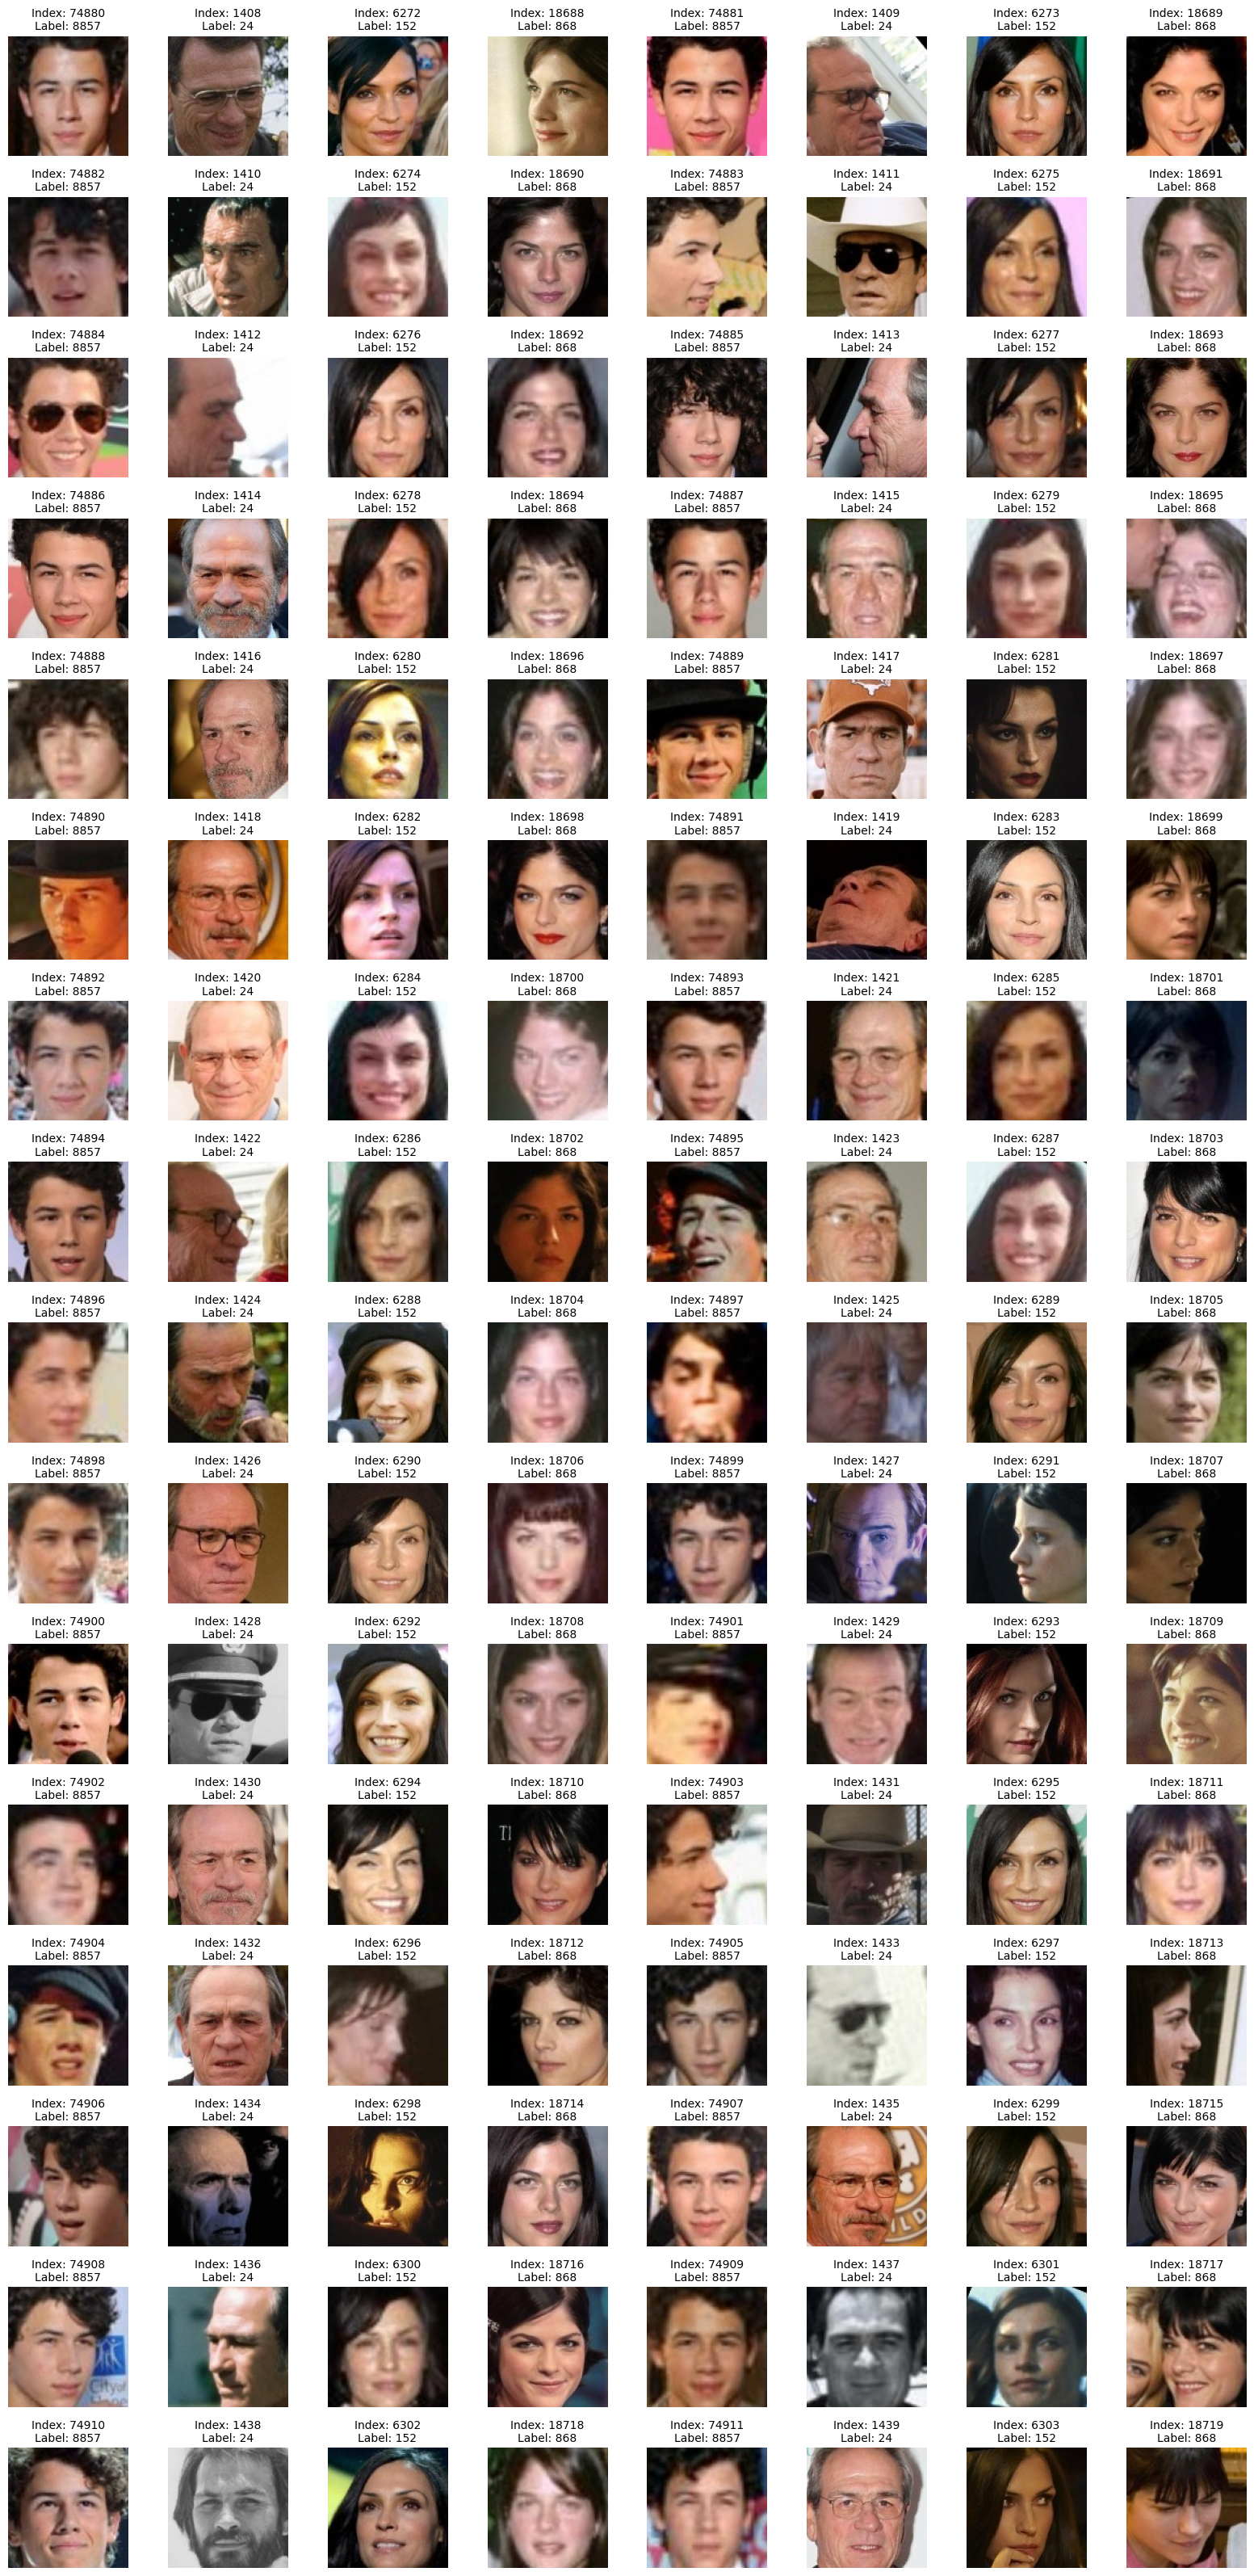

In [21]:
plot_images_side_by_side(dataset, indices, images_per_row=8)

In [22]:
# Converter o dicionário para um dataframe
res_df = pd.DataFrame.from_dict(classes, orient='index', columns=['count'])

In [23]:
# Adicionar uma linha 'Total' com a soma
df_res = pd.concat([res_df.sort_index(), pd.DataFrame(res_df.sum(), columns=['Total']).T]).T

In [24]:
df_res.shape[1]-1

4

In [25]:
df_res

24  152  868  8857  Total
count  32   32   32    32    128

In [26]:
df_res.T

count
24        32
152       32
868       32
8857      32
Total    128